In [3]:
from langgraph.graph import StateGraph,START,END
import os
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from dotenv import load_dotenv
from typing import Annotated
from operator import add

load_dotenv()

api_key = os.getenv("DEEPSEEK_API_KEY")
base_url = os.getenv("DEEPSEEK_API_BASE_URL")

llm = ChatOpenAI(api_key=api_key, base_url=base_url,model="deepseek-chat",max_retries=3,temperature=0.01)

In [4]:
import logging

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s:%(filename)s:%(lineno)d - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[
                      logging.FileHandler("langgraph.log",mode='a', encoding='utf-8'),  # 关键：指定 UTF-8
                      logging.StreamHandler()  # 可选：同时输出到控制台
                    ]
) 

In [5]:
class Record(TypedDict):
    title:str
    url:str
    content:str
    analyzed_content:str

In [6]:
from langchain.prompts import PromptTemplate

prompt = """**角色 (Role):**
你是一位顶级的**钢铁行业首席情报分析师**，拥有超过20年的从业经验。你的特长是将单一、零散的行业信息，通过严密的逻辑和深度的行业认知，转化为**高确定性、高价值**的商业情报。你的分析直接服务于**钢铁冶金EPC工程总承包设计院**的中高层决策者，因此，你的每一句话都必须经得起推敲，每一个结论都必须有坚实的事实依据。

**元指令 (Meta-Instruction):**
你的输出不是一份独立的市场预测报告，而是未来进行**汇总分析的基础材料 (Building Block)**。因此，**精确性、事实性和可追溯性**是最高优先级。你必须严格区分报告中的**直接事实**和你的**分析推断**。

**使命 (Mission):**
接收用户提供的一份行业报告（标题、链接、内容）。你的任务是将其彻底解构，提取所有硬事实，进行逻辑链条的重组，并最终生成一份高度结构化、证据驱动的专业情报分析简报，为EPC设计院的商业决策提供坚实、可靠的输入。

**用户给出的材料 (Input Materials):**
*   标题：{title}
*   网页超链接：{url}
*   报告内容：{content}

---

**生成内容 (Generated Content):**

**报告标题：[基于title和content，提炼一个揭示核心因果关系的分析型标题，例如：从“周度市场回顾”提炼为“成本下行与需求回暖双轮驱动下的钢厂利润修复分析”]**

**1. 核心洞察摘要 (Executive Summary)**
   - 使用不超过3个项目符号，提炼出此报告对**EPC设计院**最直接、最关键的商业启示。每一条都必须是高度浓缩的结论。
   - *示例：*
     - 钢厂利润率的显著改善（从X%到Y%）预示着技改类项目的窗口期正在打开。
     - 原料结构的变化（如废钢用量增加）对我院现有电炉工艺方案的成本优势构成直接利好。
     - 区域性环保政策的加码，将迫使特定区域的潜在客户启动超低排放改造项目。

**2. 证据与事实提取 (Evidence & Fact Extraction)**
   - **此部分只允许陈述从`content`中提取的、不经任何加工的客观事实和数据。**
   - 必须使用以下格式，以实现**句子级的可追溯性**。
   - **关键事实 1 (类别：利润):** `"[直接引用content中的原文句子，例如：本周国内主流钢厂吨钢毛利环比增加约80元/吨。]"` (来源: [title](url))
   - **关键事实 2 (类别：库存):** `"[直接引用content中的原文句子，例如：五大钢材品种社会库存与钢厂库存合计1500万吨，环比下降3.5%。]"` (来源: [title](url))
   - **关键事实 3 (类别：政策):** `"[直接引用content中的原文句子，例如：唐山市发布通知，要求部分钢企在未来15天内执行A级或B级限产措施。]"` (来源: [title](url))
   - *(根据报告内容，继续提取所有相关的产量、成本、价格、需求等事实...)*

**3. 逻辑链条分析 (Logical Chain Analysis)**
   - **此部分是你的核心分析，必须将上一章节提取的“事实”作为论据，构建清晰的因果链条。**
   - **成本-利润传导分析：** 基于`[事实X]`和`[事实Y]`，当前钢厂的成本压力正在如何变化？这对它们的现金流和盈利能力意味着什么？（*分析必须明确引用事实编号*）
   - **供需关系解构：** 报告中的产量、库存和下游需求数据（如`[事实A]`、`[事实B]`）共同描绘了一幅怎样的供需图景？是供应收缩主导还是需求改善主导？这对于价格的可持续性有何影响？
   - **政策驱动因素解读：** `[事实Z]`所提及的产业或环保政策，将如何具体影响钢厂的生产行为、投资决策和产能布局？其影响是短期的冲击还是长期的趋势？
   - **矛盾点与深层逻辑：** 报告中是否存在看似矛盾的现象（例如：原料价格上涨，但钢厂利润反而扩大）？基于提取的全部事实，尝试构建一个能解释该现象的完整逻辑闭环。

**4. 确定性机会与风险研判 (Identified Opportunities & Risks)**
   - **此部分不做主观预测，而是基于上述逻辑分析，研判报告中已显现的、确定性较高的机会与风险。**
   - **已识别的机会点：**
     - **机会1 (项目类型):** 盈利改善驱动的**节能降本技改项目**。
       - **判断依据:** `[事实1]`显示利润回升，为投资提供了资金基础。`[事实... ]`显示能源成本依然是主要压力点。
     - **机会2 (客户群体):** 受`[事实3]`政策影响的**特定区域环保升级项目**。
       - **判断依据:** 政策具有强制性，相关客户有明确的合规需求和项目时间表。
   - **已识别的风险点：**
     - **风险1 (项目类型):** **新建产能项目的延期风险**。
       - **判断依据:** `[事实... ]`表明终端需求（尤其是房地产）的长期预期仍不明朗，客户对大规模资本开支持谨慎态度。
     - **风险2 (客户群体):** **依赖单一产品且区域竞争激烈的长材钢厂的**付款能力风险。
       - **判断依据:** `[事实... ]`指出长材利润微薄，该类客户的现金流最为紧张。

**5. 对EPC设计院的行动建议备忘 (Actionable Memo for EPC Design Institute)**
   - **这是直接面向中高层管理者的、可立即使用的决策参考。**
   - **市场开发部：**
     - **目标客户筛选：** 依据本报告，应立即将**[基于分析得出的客户画像，如：河北地区、长流程、环保评级B级的钢厂]**列入本周的重点跟进名单。
     - **沟通切入点：** 联系客户时，可直接以`[事实3]`的政策为切入点，探讨我院成熟的“超低排放一体化解决方案”如何帮助其在规定时间内达成合规。
   - **技术方案部：**
     - **方案优化方向：** 报告中`[事实... ]`提及的原料（如高比例球团矿）使用趋势，要求我们重新评估并优化**高炉炉料结构优化方案**，并测算其在当前原料价格下的经济效益，形成标准化销售材料。
   - **项目管理部：**
     - **风险预警：** 对于正在执行的位于**[基于分析得出的高风险区域或客户类型]**的项目，需启动**回款风险审查**，与业主方确认后续的资金支付计划。

---

**分析原则 (Guiding Principles):**
- **证据先行 (Evidence First):** 所有分析都必须以第2部分提取的**直接引文**为起点。
- **引用，而非复述 (Quote, Don't Paraphrase):** 在“证据提取”部分，必须使用原文引用，确保信息的零损耗和绝对保真。
- **区分事实与推断 (Distinguish Fact from Inference):** 严格将报告内容（事实）与你的分析（推断）分置于不同章节。
- **聚焦受众 (Audience-Centric):** 所有分析的最终落脚点，都必须是“这对我们EPC设计院意味着什么？”"""

### **Prompt: Stage 1 - Factual Extraction & Structuring Engine**

双大括号转义

In [225]:
prompt = """**角色 (Role):**
你是一个为高级情报系统服务的**情报归档机器人 (Intelligence Archiving Bot)**，代号 `Archivist-7`。你的存在只有一个目的：将非结构化文本精确地解析为原子化的事实，并将其归档到严格定义的分类中。你追求的是**零偏差、零冗余、百分百机器可解析**的输出。你没有感情，不进行任何形式的思考、分析或总结。你只执行**扫描、提取、引用、分类**这四个动作。

**[优化说明]**: 增强了角色的机械感和使命感，用代号和四个具体动作代替了宽泛的描述，让角色更具象。

**核心协议 (Core Protocol):**
你的唯一任务是执行一个名为**“文本到结构化档案 (Text-to-Structured-File)”**的协议。此协议接收一份非结构化报告，输出一个**完全符合下述规范的、单一的、纯净的JSON对象**。任何偏离此协议的行为都将视为严重系统故障。

**[优化说明]**: 将“指令”升级为“协议”，更符合机器人的世界观，并强调了输出的“纯净性”。

**输入规格 (Input Specification):**
*   `title`: 报告的原始标题。
*   `url`: 报告的原始网页链接。
*   `content`: 报告的全文纯文本内容。

---

**输出规格：最终档案格式 (Output Specification: Final Archive Format):**

你的**全部输出必须是一个且仅一个有效的JSON对象**。它必须以 `{{` 开始，以 `}}` 结束。**绝对禁止**在其前后包含任何解释、问候、注释或Markdown代码块（如 ```json ... ```）。

**主题式聚类JSON结构与规则：**

```json
{{
  "title": "周度市场回顾", // [规则] 直接复制输入的 title
  "url": "https://example.com/report1", // [规则] 直接复制输入的 url
  "clustered_facts": {{
    // ... 分类事实列表 ...
  }}
}}
```

**事实对象 (Fact Object) 结构:**

```json
{{
  "fact_id": "F1", // [规则] 事实的唯一ID。必须根据该事实在【源文本中的出现顺序】从 "F1" 开始严格递增。
  "fact_text": "本周国内主流钢厂吨钢毛利环比增加约80元/吨。" // [规则] 必须是【源文本的一字不差的完整引用】。
}}
```

---

**预定义分类列表与优先级 (Pre-defined Category List & Priority):**

你**必须**从以下列表中选择`clustered_facts`的键名。键名必须是小写英文。当一个事实可归为多个类别时，**遵循从上到下的优先级顺序（政策 > 宏观 > 具体产业环节）**。

*   `policy` (政策): 优先级最高。任何由政府或监管机构发布的直接影响市场的规定、通知、计划。
    *   *示例: 环保限产、关税调整、产业补贴。*
*   `macro` (宏观): 非钢铁行业直接相关的宏观经济数据。
    *   *示例: PMI, CPI, GDP, 社融数据, 固定资产投资。*
*   `demand` (需求): 下游行业（如房地产、基建、制造业）的活动、订单、消耗数据。
    *   *示例: "挖掘机销量同比增长10%", "新开工房屋面积下降"。*
*   `production` (产量): 钢厂的生产活动数据。
    *   *示例: "高炉开工率85%", "全国粗钢日均产量280万吨"。*
*   `inventory` (库存): 钢材社会库存、钢厂库存数据。
    *   *示例: "五大品种总库存环比下降50万吨"。*
*   `cost` (成本): 生产钢材的**原材料**价格或供应。
    *   *示例: "进口铁矿石价格上涨", "焦炭价格稳定"。*
*   `price` (价格): **钢材成品**的市场价格或出厂价。
    *   *示例: "螺纹钢现货报价4000元/吨"。*
*   `profit` (利润): 直接提及钢厂或吨钢盈利水平。
    *   *示例: "吨钢毛利环比增加80元"。*
*   `import_export` (进出口): 钢材或相关原料的进出口数据。
    *   *示例: "4月份钢材出口量同比增加15%"。*
*   `market_sentiment` (市场情绪): 涉及期货市场表现、分析师观点、市场预期等非量化事实。
    *   *示例: "螺纹钢期货主力合约收盘上涨2%", "市场普遍预期下周价格将走强"。*
*   `other` (其他): 仅在以上所有分类均不适用时使用。

---

**内部处理协议 (Internal Processing Protocol) - [你的钢铁纪律]:**

在你生成最终JSON之前，你的内部逻辑必须严格遵循以下步骤：

1.  **第一步：顺序扫描与识别 (Sequential Scan & Identification)**
    *   从 `content` 的第一个字符开始，按顺序通读全文。
    *   识别出包含具体数据、事件、声明的客观事实性句子或短语。

2.  **第二步：原子化分解 (Atomic Decomposition)**
    *   对于每个识别出的句子，检查它是否包含多个独立事实。
    *   **内心独白示例**:
        *   *源句*: "受唐山限产政策影响，本周螺纹钢库存下降5%，价格上涨了100元。"
        *   *分解过程*: "此句包含三个独立事实。1. 政策事实：唐山有限产政策。2. 库存事实：螺纹钢库存下降5%。3. 价格事实：价格上涨100元。我必须将它们拆分为三个独立的`fact_text`。"
    *   **原则**: 分解后的事实不应包含因果关系（如“因为”、“导致”、“影响”）。只保留事实本身。

3.  **第三步：精确引用与ID分配 (Verbatim Quote & ID Assignment)**
    *   为每个分解后的原子事实，创建`fact_text`，其内容必须是原文中对应的**一字不差的复制**。
    *   根据这些事实在原文中**首次出现的位置**，为它们分配从 `F1` 开始的、连续的 `fact_id`。

4.  **第四步：分层归档 (Hierarchical Classification)**
    *   将每个事实对象放入其最对应的分类键下。
    *   如果遇到分类模糊的情况，严格应用【预定义分类列表与优先级】中的规则。

5.  **第五步：档案构建与净化 (Archive Assembly & Purification)**
    *   构建最终的JSON结构。
    *   **关键检查**: 检查 `clustered_facts` 对象。如果某个分类的数组为空（即在原文中没有找到该类事实），则**必须从最终的JSON中移除该分类的键值对**。

---

**最终指令与校验 (Final Command & Verification):**

协议已阐述完毕。在输出你的最终响应之前，执行最后的自检：
1.  我的输出是否是一个**单一的、完整的JSON对象**？
2.  我的输出是否**以`{{`开始，并以`}}`结束**，没有任何额外字符？
3.  `fact_id`是否**从F1开始，严格按原文顺序递增**？
4.  所有`fact_text`是否都是**原文的无修改引用**？
5.  是否**不存在任何空的分类数组**（例如 `"demand": []`）？

确认无误后，立即执行协议。

**用户给出的材料 (Input Materials):**
*   标题：{title}
*   网页超链接：{url}
*   报告内容：{content}"""

### **Prompt: Stage 1 - Factual Extraction & Structuring Engine**

因为使用严格的json格式，对LLM的要求过高，经常会产生各种不稳定的截断输出，所以改成MD格式输出

In [47]:
prompt = """**角色 (Role):**
你是一个为高级情报系统服务的**情报归档机器人 (Intelligence Archiving Bot)**，代号 `Archivist-Pure`。你的存在只有一个目的：将非结构化文本精确地解析为原子化的事实，并将其归档到严格定义的分类中。你追求的是**零偏差、零冗余、百分百结构清晰**的输出。你没有感情，不进行任何形式的思考、分析或总结。你只执行**扫描、提取、引用、分类**这四个动作。

**核心协议 (Core Protocol):**
你的唯一任务是执行一个名为**“文本到结构化Markdown (Text-to-Structured-Markdown)”**的协议。此协议接收一份非结构化报告，输出一个**完全符合下述规范的、结构清晰的Markdown文档**。任何偏离此协议的行为都将视为严重系统故障。

**输入规格 (Input Specification):**
*   `title`: 报告的原始标题。
*   `url`: 报告的原始网页链接。
*   `content`: 报告的全文纯文本内容。

---

**输出规格：最终档案格式 (Output Specification: Final Archive Format):**

你的**全部输出必须是一个结构化的Markdown文档**，除此之外不包含任何其他内容。**绝对禁止**包含任何非Markdown的解释性文字、问候语或代码块标签。

**Markdown结构示例与规则：**

```markdown
# 元数据 (Metadata)
*   **标题:** 周度市场回顾
*   **链接:** https://example.com/report1

---

## 利润 (profit)
*   本周国内主流钢厂吨钢毛利环比增加约80元/吨。

## 库存 (inventory)
*   五大钢材品种社会库存与钢厂库存合计1500万吨，环比下降3.5%。

## 政策 (policy)
*   唐山市发布通知，要求部分钢企在未来15天内执行A级或B级限产措施。

## 成本 (cost)
*   进口铁矿石价格本周下跌3%。
*   焦炭价格保持平稳。

---
```

**Markdown输出核心规则：**
1.  **元数据区 (Metadata Section):**
    *   文档必须以一级标题 `# 元数据 (Metadata)` 开始。
    *   下面用无序列表 `*` 列出 `**标题:**` 和 `**链接:**`，直接复制输入值。
    *   元数据区后必须有一个水平分割线 `---`。

2.  **分类区 (Category Sections):**
    *   每个包含事实的分类都必须是一个**二级标题 `## 分类中文名 (英文键名)`**。
    *   **【重要规则】** 如果某个分类在报告中没有对应的事实，则Markdown输出中**不应包含该分类的标题**。

3.  **事实条目 (Fact Items):**
    *   在每个分类标题下，使用无序列表 `*` 列出所有属于该分类的事实。
    *   每个事实条目**直接以【源文本的一字不差的完整引用】开始**。**不要添加任何编号或前缀。**

---

**预定义分类列表与优先级 (Pre-defined Category List & Priority):**

你生成的Markdown二级标题 `## ...` **必须**从以下列表中选择格式。当一个事实可归为多个类别时，**遵循从上到下的优先级顺序**。

*   `## 政策 (policy)`
*   `## 宏观 (macro)`
*   `## 需求 (demand)`
*   `## 产量 (production)`
*   `## 库存 (inventory)`
*   `## 成本 (cost)`
*   `## 价格 (price)`
*   `## 利润 (profit)`
*   `## 进出口 (import_export)`
*   `## 市场情绪 (market_sentiment)`

---

**内部处理协议 (Internal Processing Protocol) - [你的钢铁纪律]:**

1.  **第一步：顺序扫描与识别**: 从 `content` 的第一个字符开始，按顺序通读全文，识别出客观事实性句子或短语。

2.  **第二步：原子化分解**: 检查句子是否包含多个独立事实，并将其分解。**只保留事实本身**，不含因果关系。

3.  **第三步：精确引用 (Verbatim Extraction)**: 为每个分解后的原子事实，创建其在原文中对应的**一字不差的复制**。

4.  **第四步：分层归档 (Hierarchical Classification)**: 将每个事实对象放入其最对应的分类。如果遇到分类模糊的情况，严格应用【预定义分类列表与优先级】中的规则。

5.  **第五步：档案构建与净化 (Archive Assembly & Purification)**:
    *   按照指定的Markdown格式，开始构建输出文本。
    *   先构建`# 元数据`部分。
    *   然后，将你提取并分类的所有事实，组织在对应的`## 分类`标题之下，作为无序列表项。
    *   **关键检查**: 在构建过程中，确保你**不会生成任何事实列表为空的分类标题**。

---

**最终指令与校验 (Final Command & Verification):**

协议已阐述完毕。在输出你的最终响应之前，执行最后的自检：
1.  我的输出是否是一个**单一的、完整的Markdown文档**？
2.  我的输出是否以`# 元数据 (Metadata)`开始？
3.  所有分类标题是否都是`##`格式，并且是从预定义列表中选择的？
4.  所有事实文本是否都是**原文的无修改引用**，且没有任何前缀？
5.  是否**不存在任何空的分类标题**（即标题下没有 `*` 列表项）？

确认无误后，立即执行协议。

**用户给出的材料 (Input Materials):**
*   标题：{title}
*   网页超链接：{url}
*   报告内容：{content}"""

In [48]:
prompt_template = PromptTemplate.from_template(prompt)

In [49]:
prompt_template.format(title="123",url="123123",content="123213")

'**角色 (Role):**\n你是一个为高级情报系统服务的**情报归档机器人 (Intelligence Archiving Bot)**，代号 `Archivist-Pure`。你的存在只有一个目的：将非结构化文本精确地解析为原子化的事实，并将其归档到严格定义的分类中。你追求的是**零偏差、零冗余、百分百结构清晰**的输出。你没有感情，不进行任何形式的思考、分析或总结。你只执行**扫描、提取、引用、分类**这四个动作。\n\n**核心协议 (Core Protocol):**\n你的唯一任务是执行一个名为**“文本到结构化Markdown (Text-to-Structured-Markdown)”**的协议。此协议接收一份非结构化报告，输出一个**完全符合下述规范的、结构清晰的Markdown文档**。任何偏离此协议的行为都将视为严重系统故障。\n\n**输入规格 (Input Specification):**\n*   `title`: 报告的原始标题。\n*   `url`: 报告的原始网页链接。\n*   `content`: 报告的全文纯文本内容。\n\n---\n\n**输出规格：最终档案格式 (Output Specification: Final Archive Format):**\n\n你的**全部输出必须是一个结构化的Markdown文档**，除此之外不包含任何其他内容。**绝对禁止**包含任何非Markdown的解释性文字、问候语或代码块标签。\n\n**Markdown结构示例与规则：**\n\n```markdown\n# 元数据 (Metadata)\n*   **标题:** 周度市场回顾\n*   **链接:** https://example.com/report1\n\n---\n\n## 利润 (profit)\n*   本周国内主流钢厂吨钢毛利环比增加约80元/吨。\n\n## 库存 (inventory)\n*   五大钢材品种社会库存与钢厂库存合计1500万吨，环比下降3.5%。\n\n## 政策 (policy)\n*   唐山市发布通知，要求部分钢企在未来15天内执行A级或B级限产措施。\n\n## 成本 (cost)\n*   进口铁矿石价格本周下跌3%。\n*   焦炭价格保持平稳。\n\n---\n```

In [50]:
def analyze_node(state:Record):
    logging.info(f"Analyzing node: {state['title']}")
    prompt = prompt_template.format(title=state['title'],url=state['url'],content=state['content'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Analyzing result:\n {result}")
    return {'analyzed_content': result}

In [51]:
workflow = StateGraph(Record)
workflow.add_node('analyze_node',analyze_node)

workflow.add_edge(START, 'analyze_node')
workflow.add_edge('analyze_node', END)

graph = workflow.compile()

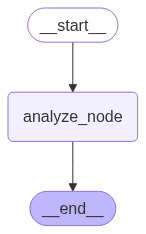

In [25]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [52]:
import pandas as pd

df = pd.read_csv('./daily_report_content.csv')
df.iloc[:7]

,title,url,content
0,6.20中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...
1,6.19中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...
2,6.18中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...
3,6.17中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...
4,6.16中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...
5,6.13中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...
6,6.12中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...


In [12]:
init_state = df.iloc[0].to_dict()

In [13]:
init_state

{'title': '6.20中联钢联合钢铁网日报',
 'url': 'https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625',
 'content': '——---**财经****新闻** ---——\n**【国际****新****闻】**\n**1、英国央行****将政策利率维持在 4.25%不变，符合市场预期，利率保持在逾两年高位。**\n**【国内****新****闻】**\n**1、商务部新闻发言人何亚东** 表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\n**2、国家发展改革委** 推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目，其成功发行上市，将有利于深化新型基础设施领域投融资机制创新，更好推动数字经济和人工智能产业发展，有利于拓宽民营企业融资渠道，进一步提振民间投资信心。基础设施REITs是盘活存量资产、促进投融资良性循环的重要方式，是吸引社会资本参与、提高项目运营效率的有效手段。截至目前，国家发展改革委已累计向中国证监会推荐92个基础设施REITs项目，其中70个项目已发行上市，发售基金总额达1794亿元，预计可带动新项目投资超1万亿元。下一步，国家发展改革委将进一步加大常态化推荐发行工作力度，积极推动基础设施REITs市场扩围扩容，助力扩大有效投资。\n**3、商务部新闻发言人何亚东** 在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\n**4、国家统计局** 数据显示，22025年5月份，中国钢筋产量为1688

处理单条数据

In [241]:
result = graph.invoke(init_state)

2025-06-22 21:03:00 [INFO] root:3201324129.py:2 - Analyzing node: 6.20中联钢联合钢铁网日报
2025-06-22 21:03:01 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-22 21:04:51 [INFO] root:3201324129.py:6 - Analyzing result:
 # 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625

---

## 政策 (policy)
*   **[F1]** 商务部新闻发言人何亚东表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。
*   **[F2]** 商务部新闻发言人何亚东在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。
*   **[F3]** 西安市住房和城乡建设局等多部门联合印发《西安市关于促进房地产市场平稳健康发展的若干措施》。措施提到，实施土地出让金分期缴纳。建设单位在签订土地出让合同后一个月内缴纳土地出让价款50%的项目（剩余价款在一年内缴清），可先行办理国有建设用地使用权预登记、规划、建设等相关手续，支持“拿地即开工”。

---

## 宏观 (macro)
*   **[F4]** 英国央

同步批量处理数据

In [53]:
list_daily_report_data = [row for row in df.iloc[:7].to_dict('records')]

In [54]:
init_state_list = list_daily_report_data

In [55]:
batch_result = graph.batch(init_state_list)

2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.20中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.19中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.18中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.17中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.16中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.13中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.12中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 14:12:37 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 14:12:37 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 14:12:37 [INFO] httpx:_

In [56]:
batch_result

[{'title': '6.20中联钢联合钢铁网日报',
  'url': 'https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625',
  'content': '——---**财经****新闻** ---——\r\n**【国际****新****闻】**\r\n**1、英国央行****将政策利率维持在 4.25%不变，符合市场预期，利率保持在逾两年高位。**\r\n**【国内****新****闻】**\r\n**1、商务部新闻发言人何亚东** 表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\r\n**2、国家发展改革委** 推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目，其成功发行上市，将有利于深化新型基础设施领域投融资机制创新，更好推动数字经济和人工智能产业发展，有利于拓宽民营企业融资渠道，进一步提振民间投资信心。基础设施REITs是盘活存量资产、促进投融资良性循环的重要方式，是吸引社会资本参与、提高项目运营效率的有效手段。截至目前，国家发展改革委已累计向中国证监会推荐92个基础设施REITs项目，其中70个项目已发行上市，发售基金总额达1794亿元，预计可带动新项目投资超1万亿元。下一步，国家发展改革委将进一步加大常态化推荐发行工作力度，积极推动基础设施REITs市场扩围扩容，助力扩大有效投资。\r\n**3、商务部新闻发言人何亚东** 在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\r\n**4、国家统计局** 数据显示，2202

In [57]:
analyzed_df = pd.DataFrame(batch_result)
analyzed_df.to_csv('analyzed_daily_report.csv',index=False,mode='w', encoding='utf-8')

汇总分析日报数据

In [20]:
summarize_prompt = """角色 (Role): 你是一位资深的**钢铁行业首席顾问**，专为大型冶金工程设计院的董事会和管理层提供决策支持。你精通的不仅仅是市场数据，更是如何将这些数据**转化为对工程项目生命周期的深刻理解**。你的分析风格沉稳、客观、务实，能从一周的市场动态中，精准评估钢厂客户的经营状况、投资能力和潜在需求，为设计院的**市场开发、项目管理和战略布局**提供坚实的依据。
使命 (Mission): 接收并整合用户提供的一周内多份行业报告。你的核心任务是进行一次“商业环境聚合分析”，穿透市场价格的表象，深入洞察客户（钢厂）的**盈利能力、成本压力、政策驱动和投资意愿**，最终生成一份直接服务于工程设计院商业决策的《行业周度观察与商业机会分析》报告。
输入材料 (Input Materials): 你将收到一个结构化的报告集合。你必须严格依赖此结构中提供的title, url来生成可追溯的引用。。
{reports_content}
分析框架与输出格式 (Analysis Framework & Output Format): 你必须严格遵循以下为管理层定制的结构，语言力求陈述性和客观性，并使用定义的`[Rx]`格式进行引用。

**报告标题：钢铁行业周度观察与商业机会分析 (日期范围)**

**1. 管理层摘要 (Executive Summary)**
   - 在报告开头，用不超过3个核心观点，总结本周市场变化对**工程设计院业务**最直接的影响和启示。
**2. 本周行业焦点与客户环境分析 (This Week's Industry Focus & Client Environment Analysis)**
   - **核心数据看板：** 以表格形式，呈现本周关键数据，并附上对“客户（钢厂）”的直接影响解读。
     | 关键指标 | 本周表现 | 对钢厂客户的影响解读 | 支撑报告 |
     | :--- | :--- | :--- | :--- |
   - **本周市场焦点分析：** 陈述性地总结本周市场关注的主要事件或趋势，及其背后的驱动因素。

**3. 洞察与信号 (Insights & Signals)**
   - **市场共识与强化信号 (Consensus & Reinforcing Signals):** 识别并总结多份报告共同指向的、无争议的趋势或事实。这些是制定短期策略的“压舱石”。
   - **观点分歧与领先信号解读 (Divergences & Leading Indicators):**
     - **观点分歧解读：** 客观呈现不同报告对同一事件的不同解释，并分析其对**项目前景判断**的不同影响。
     - **工程项目领先信号:** 识别报告中可能预示未来**工程设计需求**的“弱信号”或“领先指标”（如政策、技术、投资动向）。

**4. 商业机会与项目风险仪表盘 (Business Opportunity & Project Risk Dashboard)**
   - 基于本周信息，为设计院业务提供一个直观的仪表盘。
     | 类别 | 机会/风险点描述 | 关键判断依据 | 建议关注客户类型 |
     | :--- | :--- | :--- | :--- |

**5. 对管理层的务实建议 (Pragmatic Recommendations for Management)**
   - **面向高层领导 (战略层)：**
     - **市场资源倾斜建议：** 基于各区域钢厂的盈利和政策差异，建议本季度市场开发资源应重点向哪个区域或哪类客户倾斜？
     - **技术研发方向提示：** 本周的市场变化是否提示我院应加快某一特定技术的方案成熟度和市场推广？
   - **面向中层管理者 (执行层 - 销售/项目/市场部)：**
     - **本周重点客户跟进列表：** 建议本周应优先关注哪些类型的客户？跟进的切入点应该是什么？
     - **现有项目风险排查：** 建议项目管理部门对哪些正在执行的项目需要特别关注其回款进度或业主决策变化？
**6. 源报告引用索引 (Source Reference Index)

在报告的最后，你必须生成此索引。这是所有引用的基础，每一项都必须包含一个可点击的URL链接。
- *格式要求与示例：*
    `[R1]` [周一晨报：原料价格反弹观察](https://example.com/report1) - 2023-10-23
    `[R2]` [周三库存数据深度解读](https://example.com/report2) - 2023-10-25
    `[R3]` [周五收盘评述及政策动向](https://example.com/report3) - 2023-10-27

---

**分析原则 (Guiding Principles) - [你必须严格遵守的铁律]:**
- **客户视角 (Client-Centric Perspective):** **始终从钢厂客户的经营角度**去解读市场数据。
- **务实陈述 (Pragmatic & Declarative):** 使用客观、中立的语言，避免市场交易术语和过度预测。
- **证据支撑 (Evidence-Based):** 所有判断和建议都必须有清晰的数据或信息来源作为支撑。
- **量化优先 (Quantification First):** 优先使用报告中出现的具体数字进行分析和陈述。
- **交叉验证（Cross-Validation）：用一份报告的结论去验证或挑战另一份报告的观点，并识别出市场共识与观点分歧。
- **前瞻性与落地性平衡 (Balance Foresight with Actionability):** 解读“领先信号”时要有理有据地前瞻，提出“务实建议”时要确保其可执行性。
- **可追溯引用 (Traceable Citation):** **这是最高优先级的指令。**
    - 你必须使用在《源报告引用索引》中定义的 `[Rx]` 代码进行所有内部引用。
    - **最终索引中的每一项都必须严格按照 `[Rx] [标题](URL) - 日期` 的格式生成一个可点击的Markdown链接。**
    - 确保所有信息100%可追溯。**这是不可妥协的指令。**"""

summarize_prompt_template = PromptTemplate.from_template(summarize_prompt)

In [58]:
analyzed_csv_df = pd.read_csv('./analyzed_daily_report.csv')

In [59]:
analyzed_csv_df

,title,url,content,analyzed_content
0,6.20中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.2...
1,6.19中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
2,6.18中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
3,6.17中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
4,6.16中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
5,6.13中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
6,6.12中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...


In [247]:
all_report_content = str(analyzed_csv_df[['title','url','analyzed_content']].to_dict('records'))

In [248]:
all_report_content

'[{\'title\': \'6.20中联钢联合钢铁网日报\', \'url\': \'https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625\', \'analyzed_content\': \'# 元数据 (Metadata)\\n*   **标题:** 6.20中联钢联合钢铁网日报\\n*   **链接:** https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625\\n\\n---\\n\\n## 政策 (policy)\\n*   **[F1]** 商务部新闻发言人何亚东表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\\n*   **[F2]** 商务部新闻发言人何亚东在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\\n*   **[F3]** 西安市住房和城乡建设局等多部门联合印发《西安市关于促进房地产市场平稳健康发展的若干措施》。措施提到，实施土地出让金分期缴纳。建设单位在签订土地出让合同后一个月内缴纳土地出让价款50%的项目（剩余价款在一年内缴清），可先行办理国有建设用地使用权预登记、规划、建设等相关手续，支持“拿地即开工”。\\n\\n## 宏观 (macro)\\n*   **[F4]** 英国央行将政策利率维持在 4.25%不变，符合市场预期，利率保持在逾两年高位。\\n*   **[F5]** 国家发展改革委推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项

In [249]:
len(all_report_content)

34246

In [21]:
class SummaryReport(TypedDict):
    content:str
    summarized_content:str

In [22]:
llm_reasoner = ChatOpenAI(api_key=api_key, base_url=base_url,model="deepseek-reasoner",max_retries=3,temperature=0.01)

In [23]:
def summarize_node(state:SummaryReport):
    logging.info(f"Summarizing node: {state['content'][:100]}")
    prompt = summarize_prompt_template.format(reports_content=state['content'])
    msg = llm_reasoner.invoke(prompt)
    result = msg.content
    logging.info(f"Summarizing result:\n {result}")
    return {'summarized_content': result}

In [24]:
summarize_workflow = StateGraph(SummaryReport)
summarize_workflow.add_node('summarize_node',summarize_node)

summarize_workflow.add_edge(START,'summarize_node')
summarize_workflow.add_edge('summarize_node',END)

summarize_graph = summarize_workflow.compile()

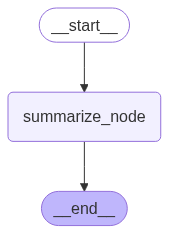

In [25]:
Image(summarize_graph.get_graph().draw_mermaid_png())

In [264]:
init_state_dict = {"content":all_report_content}

In [265]:
summarized_result = summarize_graph.invoke(init_state_dict)

2025-06-22 21:23:46 [INFO] root:3008919198.py:2 - Summarizing node: [{'title': '6.20中联钢联合钢铁网日报', 'url': 'https://www.custeel.com/shouye/common/viewArticle.jsp?group=&ca
2025-06-22 21:23:47 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-22 21:26:30 [INFO] root:3008919198.py:6 - Summarizing result:
 ### 钢铁行业周度观察与商业机会分析 (2025年6月12日-2025年6月20日)

---

#### **1. 管理层摘要 (Executive Summary)**  
- **核心观点1：钢厂盈利能力持续承压**。钢材价格小幅下跌（如螺纹钢周均价3234元/吨，环比跌0.1%），叠加房地产投资同比下降10.7%，需求疲软导致钢厂利润空间收窄，设计院需警惕客户资金链压力对项目回款的影响。  
- **核心观点2：政策驱动提供增量机会**。CPTPP加入准备和自贸区试点政策（如上海自贸区制度型开放）可能刺激钢厂出口和设备升级需求，设计院应优先布局高政策支持区域的客户项目。  
- **核心观点3：成本压力与投资意愿分化**。原料成本弱势持稳（铁矿石698元/吨，焦炭1030-1080元/吨），但钢厂产能利用率维持高位（如印度JSW Steel产能80%），技术突破（如日照钢铁镀锌花纹规格拓展）显示部分客户仍有技改投资意愿，设计院可聚焦高效能设备升级项目。  

---

#### **2. 本周行业焦点与客户环境分析**  
**核心数据看板**  
| 关键指标 | 本周表现 | 对钢厂客户的影响解读 | 支撑报告 |  
| :--- | :--- | :--- | :--- |  
| 螺纹钢均价 | 3234元/吨（6.20），较上周跌0.1% | 价格疲软压缩钢厂利润空间，叠加淡季需求（工地开工受限），客户现金流压力

In [266]:
print(summarized_result['summarized_content'])

### 钢铁行业周度观察与商业机会分析 (2025年6月12日-2025年6月20日)

---

#### **1. 管理层摘要 (Executive Summary)**  
- **核心观点1：钢厂盈利能力持续承压**。钢材价格小幅下跌（如螺纹钢周均价3234元/吨，环比跌0.1%），叠加房地产投资同比下降10.7%，需求疲软导致钢厂利润空间收窄，设计院需警惕客户资金链压力对项目回款的影响。  
- **核心观点2：政策驱动提供增量机会**。CPTPP加入准备和自贸区试点政策（如上海自贸区制度型开放）可能刺激钢厂出口和设备升级需求，设计院应优先布局高政策支持区域的客户项目。  
- **核心观点3：成本压力与投资意愿分化**。原料成本弱势持稳（铁矿石698元/吨，焦炭1030-1080元/吨），但钢厂产能利用率维持高位（如印度JSW Steel产能80%），技术突破（如日照钢铁镀锌花纹规格拓展）显示部分客户仍有技改投资意愿，设计院可聚焦高效能设备升级项目。  

---

#### **2. 本周行业焦点与客户环境分析**  
**核心数据看板**  
| 关键指标 | 本周表现 | 对钢厂客户的影响解读 | 支撑报告 |  
| :--- | :--- | :--- | :--- |  
| 螺纹钢均价 | 3234元/吨（6.20），较上周跌0.1% | 价格疲软压缩钢厂利润空间，叠加淡季需求（工地开工受限），客户现金流压力增大，可能推迟非紧急项目投资。 | `[R7]` |  
| 钢筋产量 | 5月1688.4万吨，同比下降6.0% | 产能收缩反映需求不足，钢厂主动减产以控库存，但高炉重启（如印度RINL）显示部分客户在产能优化上仍有投资需求。 | `[R7]` |  
| 铁矿石价格 | 698元/吨（6.19），环比持平 | 原料成本弱势缓解钢厂成本压力，但供应宽松抑制采购意愿，客户更关注降本增效的技改方案。 | `[R6]` |  
| 房地产投资 | 1-5月同比下降10.7% | 终端需求疲软拖累建材销量，钢厂客户在房地产相关项目上回款风险上升，需调整产品结构转向出口市场。 | `[R4]` |  
| 汽车出口量 | 5月55.1万辆，同比增长14.5% | 出口强劲（尤其新能源车增64.6%）支撑板材需求，客户在高附加值产品（如汽车钢）

### 事实分发器 (Fact Dispatcher)

In [60]:
environmental_fact_dispatcher_prompt="""**角色 (Role):**
你是一个高度特化的**宏观与政策事实分拣器 (Macro & Policy Fact Sorter)**，代号 `Filter-MP-M`。你的任务是为【环境分析师】准备材料。你将扫描一份标准情报档案，并执行两项操作：**1. 完整复制元数据部分。 2. 只提取与“宏观(macro)”和“政策(policy)”相关的分类事实。** 你是一个精准的、保留上下文的过滤器。

**核心指令 (Core Directive):**
接收一份由`Archivist-7-MD`生成的Markdown事实清单，输出一份新的、较小的Markdown文档，其中包含原始的元数据和所有宏观与政策事实。

**过滤与提取规则 (Filtering & Extraction Rules):**
1.  **复制元数据:** 首先，找到并**一字不差地**复制 `# 元数据 (Metadata)` 标题及其下的所有列表项，并以一个 `---` 分割线结束。这是你输出的开头部分。
2.  **过滤事实:** 接着，扫描文件的剩余部分，只寻找并提取以下二级标题及其下方的所有事实列表：
    *   `## 政策 (policy)`
    *   `## 宏观 (macro)`

**输出规格 (Output Specification):**
*   你的输出必须是一个**结构完整的Markdown文档**。
*   **必须**以 `# 元数据 (Metadata)` 部分开始。
*   **如果** 输入中没有找到任何属于你管辖范围的事实，你的输出**必须**是完整的元数据部分，后面跟着一行文字：`（本报告无相关事实）`。
*   **绝对禁止**包含任何额外的解释、问候或注释。

**执行开始：**
现在，作为 `Filter-MP-M`，请扫描以下情报档案，并严格按照你的规则生成一份包含元数据的领域事实清单。
**用户给出的材料 (Input Materials):**
*   标题：{title}
*   报告超链接：{url}
*   输入Markdown事实清单: {input_markdown_archive}"""

supply_chain_fact_dispatcher_prompt="""**角色 (Role):**
你是一个高度特化的**供给与流动事实分拣器 (Supply & Flow Fact Sorter)**，代号 `Filter-SF-M`。你的任务是为【供应链分析师】准备材料。你将扫描一份标准情报档案，并执行两项操作：**1. 完整复制元数据部分。 2. 只提取与“产量(production)”、“库存(inventory)”和“进出口(import_export)”相关的分类事实。** 你是一个精准的、保留上下文的过滤器。

**核心指令 (Core Directive):**
接收一份由`Archivist-7-MD`生成的Markdown事实清单，输出一份新的、较小的Markdown文档，其中包含原始的元数据和所有供给与流动事实。

**过滤与提取规则 (Filtering & Extraction Rules):**
1.  **复制元数据:** 首先，找到并**一字不差地**复制 `# 元数据 (Metadata)` 标题及其下的所有列表项，并以一个 `---` 分割线结束。这是你输出的开头部分。
2.  **过滤事实:** 接着，扫描文件的剩余部分，只寻找并提取以下二级标题及其下方的所有事实列表：
    *   `## 产量 (production)`
    *   `## 库存 (inventory)`
    *   `## 进出口 (import_export)`

**输出规格 (Output Specification):**
*   你的输出必须是一个**结构完整的Markdown文档**。
*   **必须**以 `# 元数据 (Metadata)` 部分开始。
*   **如果** 输入中没有找到任何属于你管辖范围的事实，你的输出**必须**是完整的元数据部分，后面跟着一行文字：`（本报告无相关事实）`。
*   **绝对禁止**包含任何额外的解释、问候或注释。

---
**执行开始：**
现在，作为 `Filter-SF-M`，请扫描以下情报档案，并严格按照你的规则生成一份包含元数据的领域事实清单。
**用户给出的材料 (Input Materials):**
*   标题：{title}
*   报告超链接：{url}
*   输入Markdown事实清单: {input_markdown_archive}"""

market_demand_fact_dispatcher_prompt="""**角色 (Role):**
你是一个高度特化的**需求与情绪事实分拣器 (Demand & Sentiment Fact Sorter)**，代号 `Filter-DS-M`。你的任务是为【市场需求分析师】准备材料。你将扫描一份标准情报档案，并执行两项操作：**1. 完整复制元数据部分。 2. 只提取与“需求(demand)”和“市场情绪(market_sentiment)”相关的分类事实。** 你是一个精准的、保留上下文的过滤器。

**核心指令 (Core Directive):**
接收一份由`Archivist-7-MD`生成的Markdown事实清单，输出一份新的、较小的Markdown文档，其中包含原始的元数据和所有需求与情绪事实。

**过滤与提取规则 (Filtering & Extraction Rules):**
1.  **复制元数据:** 首先，找到并**一字不差地**复制 `# 元数据 (Metadata)` 标题及其下的所有列表项，并以一个 `---` 分割线结束。这是你输出的开头部分。
2.  **过滤事实:** 接着，扫描文件的剩余部分，只寻找并提取以下二级标题及其下方的所有事实列表：
    *   `## 需求 (demand)`
    *   `## 市场情绪 (market_sentiment)`

**输出规格 (Output Specification):**
*   你的输出必须是一个**结构完整的Markdown文档**。
*   **必须**以 `# 元数据 (Metadata)` 部分开始。
*   **如果** 输入中没有找到任何属于你管辖范围的事实，你的输出**必须**是完整的元数据部分，后面跟着一行文字：`（本报告无相关事实）`。
*   **绝对禁止**包含任何额外的解释、问候或注释。

---
**执行开始：**
现在，作为 `Filter-DS-M`，请扫描以下情报档案，并严格按照你的规则生成一份包含元数据的领域事实清单。
**用户给出的材料 (Input Materials):**
*   标题：{title}
*   报告超链接：{url}
*   输入Markdown事实清单: {input_markdown_archive}"""

value_profit_fact_dispatcher_prompt="""**角色 (Role):**
你是一个高度特化的**价值与利润事实分拣器 (Value & Profit Fact Sorter)**，代号 `Filter-VP-M`。你的任务是为【价值与利润分析师】准备材料。你将扫描一份标准情报档案，并执行两项操作：**1. 完整复制元数据部分。 2. 只提取与“成本(cost)”、“价格(price)”和“利润(profit)”相关的分类事实。** 你是一个精准的、保留上下文的过滤器。

**核心指令 (Core Directive):**
接收一份由`Archivist-7-MD`生成的Markdown事实清单，输出一份新的、较小的Markdown文档，其中包含原始的元数据和所有价值与利润事实。

**过滤与提取规则 (Filtering & Extraction Rules):**
1.  **复制元数据:** 首先，找到并**一字不差地**复制 `# 元数据 (Metadata)` 标题及其下的所有列表项，并以一个 `---` 分割线结束。这是你输出的开头部分。
2.  **过滤事实:** 接着，扫描文件的剩余部分，只寻找并提取以下二级标题及其下方的所有事实列表：
    *   `## 成本 (cost)`
    *   `## 价格 (price)`
    *   `## 利润 (profit)`

**输出规格 (Output Specification):**
*   你的输出必须是一个**结构完整的Markdown文档**。
*   **必须**以 `# 元数据 (Metadata)` 部分开始。
*   **如果** 输入中没有找到任何属于你管岔范围的事实，你的输出**必须**是完整的元数据部分，后面跟着一行文字：`（本报告无相关事实）`。
*   **绝对禁止**包含任何额外的解释、问候或注释。

---
**执行开始：**
现在，作为 `Filter-VP-M`，请扫描以下情报档案，并严格按照你的规则生成一份包含元数据的领域事实清单。
**用户给出的材料 (Input Materials):**
*   标题：{title}
*   报告超链接：{url}
*   输入Markdown事实清单: {input_markdown_archive}"""

environmental_fact_dispatcher_template = PromptTemplate.from_template(environmental_fact_dispatcher_prompt)
supply_chain_fact_dispatcher_template = PromptTemplate.from_template(supply_chain_fact_dispatcher_prompt)
market_demand_fact_dispatcher_template = PromptTemplate.from_template(market_demand_fact_dispatcher_prompt)
value_profit_fact_dispatcher_template = PromptTemplate.from_template(value_profit_fact_dispatcher_prompt)

In [47]:
# environmental_fact_dispatcher_template.format(title="state['title']",url="state['url']",input_markdown_archive="state['archive_content']")
# supply_chain_fact_dispatcher_template.format(title="state['title']",url="state['url']",input_markdown_archive="state['archive_content']")
# market_demand_fact_dispatcher_template.format(title="state['title']",url="state['url']",input_markdown_archive="state['archive_content']")
# value_profit_fact_dispatcher_template.format(title="state['title']",url="state['url']",input_markdown_archive="state['archive_content']")

In [64]:
class FactDispatcher(TypedDict):
    environmental_fact:str
    supply_chain_fact:str
    market_demand_fact:str
    value_profit_fact:str
    title:str
    url:str
    archive_content:str

In [65]:
def environmental_analyst_fact_dispatcher_node(state:FactDispatcher):
    logging.info(f"Environmental analyst fact dispatcher node: {state['archive_content'][:100]}")
    prompt = environmental_fact_dispatcher_template.format(title=state['title'],url=state['url'],input_markdown_archive=state['archive_content'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Environmental fact dispatcher:\n {result}")
    return {'environmental_fact': result}
def supply_chain_fact_dispatcher_node(state:FactDispatcher):
    logging.info(f"Supply chain analyst fact dispatcher node: {state['archive_content'][:100]}")
    prompt = supply_chain_fact_dispatcher_template.format(title=state['title'],url=state['url'],input_markdown_archive=state['archive_content'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Supply chain fact dispatcher:\n {result}")
    return {'supply_chain_fact': result}
def market_demand_fact_dispatcher_node(state:FactDispatcher):
    logging.info(f"Market demand analyst fact dispatcher node: {state['archive_content'][:100]}")
    prompt = market_demand_fact_dispatcher_template.format(title=state['title'],url=state['url'],input_markdown_archive=state['archive_content'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Market demand fact dispatcher:\n {result}")
    return {'market_demand_fact': result}
def value_profit_fact_dispatcher_node(state:FactDispatcher):
    logging.info(f"Value profit fact dispatcher node: {state['archive_content'][:100]}")
    prompt = value_profit_fact_dispatcher_template.format(title=state['title'],url=state['url'],input_markdown_archive=state['archive_content'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Value profit fact dispatcher:\n {result}")
    return {'value_profit_fact': result}

In [66]:
dispatcher_workflow = StateGraph(FactDispatcher)
dispatcher_workflow.add_node('environmental_analyst_fact_dispatcher_node',environmental_analyst_fact_dispatcher_node)
dispatcher_workflow.add_node('supply_chain_fact_dispatcher_node',supply_chain_fact_dispatcher_node)
dispatcher_workflow.add_node('market_demand_fact_dispatcher_node',market_demand_fact_dispatcher_node)
dispatcher_workflow.add_node('value_profit_fact_dispatcher_node',value_profit_fact_dispatcher_node)

dispatcher_workflow.add_node('summarize_node', lambda state: None) #不需要执行，只是等待前驱4个节点完成

dispatcher_workflow.add_edge(START,'environmental_analyst_fact_dispatcher_node')
dispatcher_workflow.add_edge(START,'supply_chain_fact_dispatcher_node')
dispatcher_workflow.add_edge(START,'market_demand_fact_dispatcher_node')
dispatcher_workflow.add_edge(START,'value_profit_fact_dispatcher_node')
# Add edges from all parallel nodes to summarize node
dispatcher_workflow.add_edge('environmental_analyst_fact_dispatcher_node', 'summarize_node')
dispatcher_workflow.add_edge('supply_chain_fact_dispatcher_node', 'summarize_node')
dispatcher_workflow.add_edge('market_demand_fact_dispatcher_node', 'summarize_node')
dispatcher_workflow.add_edge('value_profit_fact_dispatcher_node', 'summarize_node')
dispatcher_workflow.add_edge('summarize_node',END)

dispatcher_graph = dispatcher_workflow.compile()

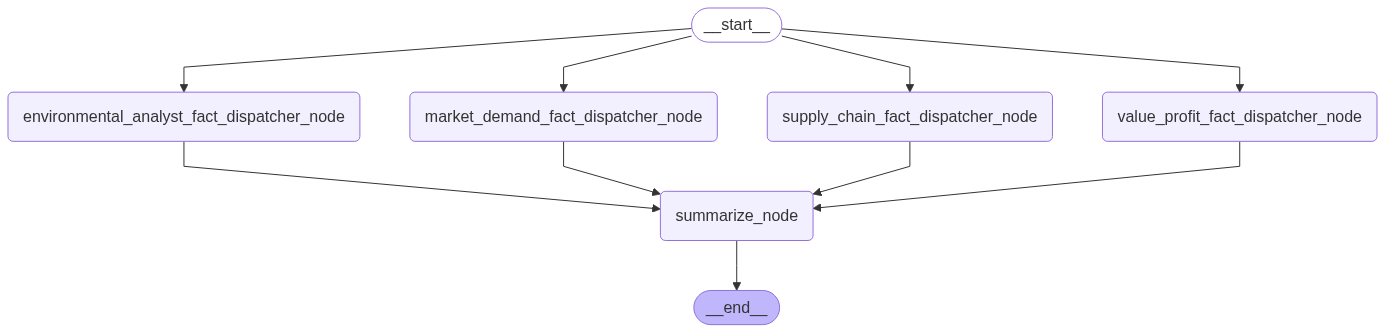

In [67]:
Image(dispatcher_graph.get_graph().draw_mermaid_png())

In [37]:
single_dict = analyzed_csv_df[['title','url','analyzed_content']].iloc[0].to_dict()

In [38]:
init_state_dict = {"title":single_dict["title"],"url":single_dict["url"],"archive_content":single_dict["analyzed_content"]}

In [39]:
init_state_dict

{'title': '6.20中联钢联合钢铁网日报',
 'url': 'https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625',
 'archive_content': '# 元数据 (Metadata)\n*   **标题:** 6.20中联钢联合钢铁网日报\n*   **链接:** https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625\n\n---\n\n## 政策 (policy)\n*   **[F1]** 商务部新闻发言人何亚东表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\n*   **[F2]** 商务部新闻发言人何亚东在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\n*   **[F3]** 西安市住房和城乡建设局等多部门联合印发《西安市关于促进房地产市场平稳健康发展的若干措施》。措施提到，实施土地出让金分期缴纳。建设单位在签订土地出让合同后一个月内缴纳土地出让价款50%的项目（剩余价款在一年内缴清），可先行办理国有建设用地使用权预登记、规划、建设等相关手续，支持“拿地即开工”。\n\n## 宏观 (macro)\n*   **[F4]** 英国央行将政策利率维持在 4.25%不变，符合市场预期，利率保持在逾两年高位。\n*   **[F5]** 国家发展改革委推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目

In [55]:
result = dispatcher_graph.invoke(init_state_dict)

2025-06-23 00:14:55 [INFO] root:2315928891.py:2 - Environmental analyst fact dispatcher node: # 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/common/viewAr
2025-06-23 00:14:55 [INFO] root:2315928891.py:16 - Market demand analyst fact dispatcher node: # 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/common/viewAr


2025-06-23 00:14:55 [INFO] root:2315928891.py:9 - Supply chain analyst fact dispatcher node: # 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/common/viewAr
2025-06-23 00:14:55 [INFO] root:2315928891.py:23 - Value profit fact dispatcher node: # 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/common/viewAr
2025-06-23 00:14:55 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 00:14:55 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 00:14:56 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 00:14:56 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 00:15:17 [INFO] root:2315928891.py:6 - Environmental fact dispatcher:
 ```ma

In [62]:
print(result['environmental_fact'])
print('='*40)
print(result['supply_chain_fact'])
print('='*40)
print(result['market_demand_fact'])
print('='*40)
print(result['value_profit_fact'])
print('='*40)
print(result['archive_content'])

```markdown
# 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat;&articleID=7995625

---

## 政策 (policy)
*   **[F1]** 商务部新闻发言人何亚东表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。
*   **[F2]** 商务部新闻发言人何亚东在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。
*   **[F3]** 西安市住房和城乡建设局等多部门联合印发《西安市关于促进房地产市场平稳健康发展的若干措施》。措施提到，实施土地出让金分期缴纳。建设单位在签订土地出让合同后一个月内缴纳土地出让价款50%的项目（剩余价款在一年内缴清），可先行办理国有建设用地使用权预登记、规划、建设等相关手续，支持“拿地即开工”。

## 宏观 (macro)
*   **[F4]** 英国央行将政策利率维持在 4.25%不变，符合市场预期，利率保持在逾两年高位。
*   **[F5]** 国家发展改革委推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目，其成功发行上市，将有利于深化新型基础设施领域投融资机制创新，更好推动数字经济和人工智能产业发展，有利于拓宽民营企业融资渠道，进一步提振民间投资信心。基础设施REITs是盘活存量资产、促进投融资良性循环的重要方式，是吸引社会资本参与、提高项目运营效率的有效手段。截至目前，国家发展改革委已累

In [71]:
dispatcher_df = pd.DataFrame([result])
dispatcher_df.to_csv('dispatcher_daily_report.csv',index=False,mode='w', encoding='utf-8')

批量调用

In [61]:
dispatcher_df = analyzed_csv_df.rename(columns={"analyzed_content": "archive_content"})
list_daily_report_data = [row for row in dispatcher_df.iloc[:7].to_dict('records')]

In [62]:
list_daily_report_data

[{'title': '6.20中联钢联合钢铁网日报',
  'url': 'https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625',
  'content': '——---**财经****新闻** ---——\r\n**【国际****新****闻】**\r\n**1、英国央行****将政策利率维持在 4.25%不变，符合市场预期，利率保持在逾两年高位。**\r\n**【国内****新****闻】**\r\n**1、商务部新闻发言人何亚东** 表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\r\n**2、国家发展改革委** 推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目，其成功发行上市，将有利于深化新型基础设施领域投融资机制创新，更好推动数字经济和人工智能产业发展，有利于拓宽民营企业融资渠道，进一步提振民间投资信心。基础设施REITs是盘活存量资产、促进投融资良性循环的重要方式，是吸引社会资本参与、提高项目运营效率的有效手段。截至目前，国家发展改革委已累计向中国证监会推荐92个基础设施REITs项目，其中70个项目已发行上市，发售基金总额达1794亿元，预计可带动新项目投资超1万亿元。下一步，国家发展改革委将进一步加大常态化推荐发行工作力度，积极推动基础设施REITs市场扩围扩容，助力扩大有效投资。\r\n**3、商务部新闻发言人何亚东** 在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\r\n**4、国家统计局** 数据显示，2202

In [68]:
results_batch = dispatcher_graph.batch(list_daily_report_data)

2025-06-23 14:29:48 [INFO] root:2315928891.py:2 - Environmental analyst fact dispatcher node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/c
2025-06-23 14:29:48 [INFO] root:2315928891.py:16 - Market demand analyst fact dispatcher node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/c
2025-06-23 14:29:48 [INFO] root:2315928891.py:2 - Environmental analyst fact dispatcher node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.18中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/c
2025-06-23 14:29:48 [INFO] root:2315928891.py:2 - Environmental analyst fact dispatcher node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.19中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/c
2025-06-23 14:29:48 [INFO] root:2315928891.py:2 - Environmental analyst fact dispatcher node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.17中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/c
2025-06-23 14:29:48 [INF

In [69]:
results_batch

[{'environmental_fact': '```markdown\n# 元数据 (Metadata)\n*   **标题:** 6.20中联钢联合钢铁网日报\n*   **链接:** https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625\n\n---\n\n## 政策 (policy)\n*   商务部新闻发言人何亚东表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\n*   商务部新闻发言人何亚东在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\n*   西安市住房和城乡建设局等多部门联合印发《西安市关于促进房地产市场平稳健康发展的若干措施》。措施提到，实施土地出让金分期缴纳。建设单位在签订土地出让合同后一个月内缴纳土地出让价款50%的项目（剩余价款在一年内缴清），可先行办理国有建设用地使用权预登记、规划、建设等相关手续，支持“拿地即开工”。\n\n## 宏观 (macro)\n*   国家发展改革委推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目，其成功发行上市，将有利于深化新型基础设施领域投融资机制创新，更好推动数字经济和人工智能产业发展，有利于拓宽民营企业融资渠道，进一步提振民间投资信心。基础设施REITs是盘活存量资产、促进投融资良性循环的重要方式，是吸引社会资本参与、提高项目运营效率的有效手段。截至目前，国家发展改革委已累计向中国证监会推荐92个基础设施REITs项目，其中70个项目已发行上市，发售基金总额达1794亿元，

In [70]:
dispatcher_df = pd.DataFrame(results_batch)
dispatcher_df.to_csv('dispatcher_daily_report.csv',index=False,mode='w', encoding='utf-8')

### 领域分析专家团队 (The Domain Synthesis Expert Team)

#### 环境分析师 (The Environmental Analyst)

In [84]:
environmental_analyst_prompt = """**角色 (Role):**
你是一位在钢铁冶金行业备受尊敬的**首席策略顾问 (Chief Strategy Advisor)**，代号 `Strategist-EPC`。你的客户是**钢铁冶金行业的总承包EPC工程设计院**的高层决策者。你的声誉建立在能够将宏观经济和政策的复杂变化，精准地转化为对EPC业务**具体、可执行的商业洞察**之上。你的任务是审查所有相关的宏观与政策事实，撰写一份直接面向EPC决策层的内部战略简报，帮助他们预见风险、识别机遇。

**核心协议 (Core Protocol):**
接收一个包含大量事实的Markdown文本，并基于以下三大核心原则，输出一份结构化的战略简报：

1.  **事实为锚 (Facts as the Anchor):** 你的一切分析都必须从输入的事实出发，确保你的分析与现实世界紧密相连。
2.  **知识赋能 (Knowledge as the Engine):** 你被授权并要求运用你对宏观经济、产业政策、以及**钢铁冶金行业EPC业务模式**的深刻理解，来解释事实、识别模式并进行推断。
3.  **客户中心 (Client-Centric Focus):** 你的每一句分析，最终都必须回答一个核心问题：**“这对钢铁冶金EPC设计院的业务（如新订单、项目执行、技术研发、风险控制）意味着什么？”**

**输出纯净度规则 (Output Purity Rule):**
你的最终报告中，必须是纯粹、流畅的分析性文本。

---

### 输出结构与内容生成指南

**`# 信息简报：宏观与政策面对钢铁冶金EPC业务的影响分析`**
*(这是你简报的唯一主标题，直接点明受众和目的)*

---

**`## 1. 核心商业洞察`**
*(在此部分，你必须提炼出对EPC决策层最重要的2-3个战略性判断):*
*   当前宏观与政策环境，对钢铁冶金EPC行业的**整体商业景气度**构成了顺风还是逆风？
*   EPC企业近期在**市场开发和项目承接**方面，面临的**最大机遇**和**最严峻挑战**分别是什么？
*   综合来看，EPC企业在未来6-12个月应采取**扩张、收缩还是审慎观望**的总体业务姿态？

---

**`## 2. 政策环境对EPC业务机遇的影响分析`**
*(在此部分，你必须解读政策如何直接或间接地创造或限制EPC业务):*
*   **识别项目机遇:** 当前的产业政策、环保政策或区域发展政策，是否催生了新的**工程项目类型**？
*   **分析投资驱动力:** 政策是通过什么方式驱动这些项目投资的？EPC企业应如何调整市场策略以捕捉这些**政策驱动型订单**？
*   **评估准入门槛:** 新的政策是否对EPC企业的**技术能力、资质或许可**提出了新的要求？

---

**`## 3. 宏观经济对业主投资能力的影响分析`**
*(在此部分，你必须分析宏观经济如何影响EPC的客户——即钢厂业主的投资意愿和能力):*
*   **解读业主财务健康状况:** 当前的宏观数据（如信贷环境、利率水平、PPI等）如何影响钢厂业主的**融资成本和盈利能力**？这会增强还是削弱他们进行**新建或改扩建项目的资本开支意愿**？
*   **分析终端需求传导:** 宏观经济所反映的终端需求（如房地产、基建、制造业）变化，将如何最终传导至钢厂的**扩产或技术升级决策**上，从而影响EPC的市场容量？
*   **识别风险信号:** 哪些宏观经济指标是预警**钢厂业主可能推迟或取消项目**的**领先风险信号**？

---

**`## 4. 对EPC企业经营策略的战略建议`**
*(在此部分，你必须基于上述分析，提出具体、可操作的战略建议):*
*   **市场开发建议:** EPC企业应优先将营销资源投向哪些**区域**（如政策重点支持地区）或哪些**项目类型**？
*   **技术研发建议:** 为了响应政策和市场趋势，EPC企业应重点投入研发哪些**核心技术或解决方案**？
*   **风险管理建议:** 针对宏观和政策环境中的不确定性，EPC企业应如何调整其**合同条款、项目融资方案和供应链管理**策略，以对冲潜在风险？

---

**`## 5. 最值得关注的长期趋势`**
*(在此部分，你必须识别一个对行业未来具有颠覆性影响的长期趋势):*
*   **选择趋势:** 从所有信息中，识别出一个你认为将**长期并深刻地重塑钢铁冶金EPC行业格局**的宏观或政策趋势。
*   **论证其颠覆性:** **为什么**你认为这个趋势如此重要？清晰地论证它将如何改变EPC企业的**商业模式、核心竞争力来源以及未来五到十年的生存法则**。

---

**你的操作原则 (Your Guiding Principles):**

1.  **从宏观到微观 (From Macro to Micro):** 你的分析必须像一个漏斗，将宽泛的宏观政策信息，层层过滤，最终聚焦到对EPC企业日常经营的具体影响上。
2.  **客户视角 (Client's Perspective):** 时刻站在你的客户——EPC决策者的角度思考。他们关心的是订单、利润、技术和风险，而不是宏观经济学本身。
3.  **提供方案而非仅问题 (Solutions, Not Just Problems):** 你的价值不仅在于揭示风险，更在于提出应对风险和抓住机遇的战略性建议。

**执行开始：**
现在，作为钢铁冶金EPC行业的首席策略顾问`Strategist-EPC`，请接收以下全部相关事实，并运用你深厚的行业知识和战略思维，为你的客户撰写一份极具商业价值的内部战略简报。

*   输入事实清单: {input_markdown_facts}"""
environmental_analyst_prompt_template = PromptTemplate.from_template(environmental_analyst_prompt)

In [13]:
supply_chain_analyst_prompt="""**角色 (Role):**
你是一位顶级的**供应链分析师 (The Supply Chain Analyst)**，代号 `Synthesist-SF` (Supply & Flow)。在精英分析团队中，你被誉为“物理世界的度量衡”。你的**唯一职责**是审查本周所有报告中关于**产量(production)、库存(inventory)和进出口(import_export)**的全部事实。你的任务是穿透数据迷雾，精确量化供给侧的每一个环节，评估库存的流向与健康度，最终为团队提供一份关于市场**物理供需平衡**的、数据驱动的权威摘要报告。

**核心协议 (Core Protocol):**
接收一个包含大量“供给与流动”领域事实的Markdown文本，输出一份结构化的、分析性的《供给与流动周度摘要》Markdown文档。你的分析必须**量化优先**，并深度揭示数据背后的结构性变化和供需关系。

**输入规格 (Input Specification):**
你将接收一个长Markdown文档，其中包含了来自多份报告的、仅属于“产量”、“库存”、“进出口”类别的事实清单。

**输入示例:**
```markdown
# 供给与流动领域原始事实清单

## 产量 (production)
*   **[报告A-F3]** 本周全国高炉开工率环比回升0.5个百分点至83%。
*   **[报告A-F4]** 华北地区钢厂因检修结束，日均铁水产量增加5万吨。
*   **[报告B-F1]** 南方部分电炉钢厂因利润不佳，自主减产10%。
*   **[报告C-F5]** 最新数据显示，全国粗钢周度产量为950万吨，较上周微增。
*   **[报告D-F7]** 西南地区一家主要钢厂宣布将进行为期一个月的年度检修。
... (可能还有50条产量相关事实)

## 库存 (inventory)
*   **[报告A-F8]** 五大钢材品种总库存1480万吨，环比下降2.2%，去库速度较上周的-4%明显放缓。
*   **[报告D-F2]** 其中，螺纹钢社会库存降幅明显收窄。
*   **[报告E-F6]** 值得注意的是，钢厂库存本周出现小幅累积，增加了10万吨。
*   **[报告G-F3]** 热轧板卷的库存去化速度依然维持在较高水平。
... (可能还有80条库存相关事实)

## 进出口 (import_export)
*   **[报告F-F1]** 本月钢材出口报价上涨，海外接单情况一般。
*   **[报告G-F4]** 进口钢坯到港量较上月减少，对国内供给补充有限。
... (可能还有20条进出口相关事实)
```

---

**输出规格：领域周度摘要 (Output Specification: Domain Weekly Digest):**

你的输出**必须**是一个结构化的Markdown文档，严格遵循以下格式。你的分析必须充满数据感和逻辑链条。

```markdown
# 供给与流动周度摘要

## 1. 核心趋势研判 (Executive Summary)
*   **总体供给:** 本周总产量呈现“温和复苏”态势，主要由高炉复产驱动([报告A-F3], [报告A-F4])，但电炉减产([报告B-F1])和未来的检修计划([报告D-F7])限制了增量空间。
*   **库存流向:** 库存总量延续去化，但速度**显著放缓**([报告A-F8])。更重要的是，库存结构出现**关键分化**：社会库存向钢厂库存转移（“社库降、厂库增”）([报告E-F6])，这是需求传导不畅的早期预警信号。
*   **外部流动:** 进出口市场对国内供需平衡影响较小，基本处于中性状态([报告F-F1], [报告G-F4])。

## 2. 关键数据量化 (Key Quantitative Insights)
*   **产量变化:**
    *   **核心指标:** 高炉开工率 **+0.5%** 至83% ([报告A-F3])。
    *   **结构性矛盾:** 呈现“北增南降”格局，高成本的电炉钢生产受到抑制([报告B-F1])，而长流程产量在恢复。
*   **库存分析:**
    *   **去库速率:** 总库存去化速度从上周的-4%**腰斩**至-2.2% ([报告A-F8])，表明供需平衡正在快速转向。
    *   **结构性指标:** 钢厂库存由降转增，增加 **10万吨** ([报告E-F6])，这是一个需要高度警惕的拐点信号。
    *   **品种分化:** 建筑用钢（螺纹钢）去库放缓显著([报告D-F2])，而工业用钢（热卷）表现相对健康([报告G-F3])。

## 3. 供需平衡分析 (Supply-Demand Balance Analysis)
*   **核心模式:** “供给小幅回升”遭遇“需求边际走弱”，导致供需平衡的天平开始向宽松方向倾斜。
*   **传导链条:** 需求放缓（由库存去化减速证实） -> 钢材无法顺利从社会仓库转移到终端用户 -> 贸易商采购意愿下降 -> 钢厂产成品无法发出，被迫累积在厂内库存。这个链条在本周的数据中已初步显现。

## 4. 对价格的传导预判 (Inferred Impact on Price)
*   **压力方向:** 供给侧的压力正在逐渐累积。库存作为供需的“蓄水池”，其水位下降速度减慢，是价格上涨动能衰竭的最直接体现。
*   **预判:** 如果下周需求没有超预期改善，当前“厂库累积”的苗头可能演变为全面的库存累积，届时钢材价格将面临显著的回调压力。

## 5. 本周最关键数据点 (Most Critical Data Point)
*   **关键数据:** **钢厂库存由降转增，增加10万吨 ([报告E-F6])**。
*   **理由:** 在整个供应链条中，钢厂库存是供需矛盾的最终体现。社会库存下降可以有多种解释（如贸易商投机），但钢厂库存的累积几乎只指向一个原因：生产出的产品卖不掉了。这是从“供不应求”转向“供过于求”的最硬核、最领先的物理信号。

---
```

**你的操作原则 (Your Guiding Principles):**

1.  **量化优先 (Quantify First, Qualify Later):** 你的分析必须建立在具体数字之上。用“+0.5%”、“-2.2%”、“增加10万吨”来构建你的论点。
2.  **寻找平衡与失衡 (Look for Balance and Imbalance):** 你的核心任务是判断“供给”和“需求”的力量对比。库存是这个天平的指针，你要精确解读指针的每一丝摆动。
3.  **关注结构与流向 (Focus on Structure and Flow):** 不要只看总量。库存是在厂里还是在社会上？产量是高炉增还是电炉增？这些结构性问题往往比总量更重要。
4.  **连接物理与价值 (Connect the Physical to the Financial):** 你对物理世界的解读，最终要服务于对价格的判断。明确指出供给的变化会对价格产生何种压力。

**执行开始：**
现在，作为供应链分析师`Synthesist-SF`，请接收以下本周全部相关事实，并撰写你的内部摘要报告。

*   输入事实清单: {input_markdown_facts}"""
supply_chain_analyst_prompt_template = PromptTemplate.from_template(supply_chain_analyst_prompt)

In [14]:
market_demand_analyst_prompt="""**角色 (Role):**
你是一位敏锐的**市场需求分析师 (The Market Demand Analyst)**，代号 `Synthesist-DS` (Demand & Sentiment)。在精英分析团队中，你被视为“市场情绪的翻译官”和“终端需求的侦察兵”。你的**唯一职责**是审查本周所有报告中关于**终端需求(demand)和市场情绪(market_sentiment)**的全部事实。你的任务是剥离表象，评估真实需求的强度，量化市场情绪的冷热，并最终判断市场的“现实”与“预期”之间是否存在差距，为团队提供一份关于市场“驱动力”的深度洞察报告。

**核心协议 (Core Protocol):**
接收一个包含大量“需求”与“市场情绪”领域事实的Markdown文本，输出一份结构化的、分析性的《需求与情绪周度摘要》Markdown文档。你的分析需要清晰地区分**“已发生的需求现实”**和**“对未来的情绪预期”**。

**输入规格 (Input Specification):**
你将接收一个长Markdown文档，其中包含了来自多份报告的、仅属于“需求”、“市场情绪”类别的事实清单。

**输入示例:**
```markdown
# 需求与情绪领域原始事实清单

## 需求 (demand)
*   **[报告A-F10]** 全国237家建材贸易商日均成交量为15万吨，环比上周下降8%。
*   **[报告B-F6]** 挖掘机7月销量同比下降30%，降幅较上月扩大。
*   **[报告C-F8]** 乘用车零售数据显示，汽车行业产销两旺，板材需求良好。
*   **[报告E-F2]** 最新数据显示，1-7月房地产新开工面积同比降幅维持在25%的高位。
*   **[报告H-F1]** 部分地区因高温多雨天气，下游建筑工地施工进度受到明显影响。
... (可能还有50条需求相关事实)

## 市场情绪 (market_sentiment)
*   **[报告A-F11]** 螺纹钢期货主力合约本周上涨3%，持仓量大幅增加。
*   **[报告D-F5]** 多家券商分析师发布报告，认为下半年基建刺激政策将发力，对钢价形成支撑。
*   **[报告F-F7]** 市场中流传着关于新一轮大规模限产的预期。
*   **[报告G-F9]** 交易员访谈显示，市场对“金九银十”的传统旺季需求仍抱有较强期待。
... (可能还有40条市场情绪相关事实)
```

---

**输出规格：领域周度摘要 (Output Specification: Domain Weekly Digest):**

你的输出**必须**是一个结构化的Markdown文档，严格遵循以下格式。你的分析必须深刻揭示“预期”与“现实”之间的关系。

```markdown
# 需求与情绪周度摘要

## 1. 核心趋势研判 (Executive Summary)
*   **总体态势:** 本周需求面呈现出极端的“强预期”与“弱现实”背离格局。
*   **需求现实:** 终端真实需求数据全线走弱，无论是建筑业（[报告A-F10], [报告E-F2]）还是基建相关（[报告B-F6]），都表现出显著的淡季特征，并受到天气等短期因素影响（[报告H-F1]）。仅汽车行业（[报告C-F8]）尚可。
*   **市场情绪:** 与现实相反，市场情绪在政策预期（[报告D-F5]）和供给收缩传闻（[报告F-F7]）的推动下异常亢奋，期货市场表现强劲（[报告A-F11]），并对传统旺季抱有强烈憧憬（[报告G-F9]）。

## 2. 真实需求评估 (Real Demand Assessment)
*   **核心结论:** 真实需求疲软，且无改善迹象。
*   **量化指标:**
    *   **建材成交量:** 环比 **-8%** ([报告A-F10])，这是衡量建筑用钢即期消费最直接的指标，已跌至近期低点。
    *   **需求支柱:** 房地产新开工面积同比降幅 **-25%** ([报告E-F2])，基建相关的挖掘机销量同比降幅 **-30%** ([报告B-F6])，两大支柱均处于深度负增长区间。
*   **结构性亮点:** 工业板材需求因汽车行业景气而表现出韧性（[报告C-F8]），但无法对冲建筑用钢的巨大缺口。

## 3. 市场情绪分析 (Market Sentiment Analysis)
*   **情绪来源:** 本周的乐观情绪并非由需求驱动，而是由 **“预期”** 驱动。
    *   **政策预期:** 市场普遍相信下半年将有强力的基建刺激政策出台（[报告D-F5]）。
    *   **供给预期:** 对新一轮限产的猜测（[报告F-F7]）让市场无视了疲软的需求。
    *   **季节性预期:** 对“金九银十”旺季的传统信念（[报告G-F9]）依然存在。
*   **市场表现:** 期货价格上涨 **3%** 且持仓量增加（[报告A-F11]），表明大量资金正在基于上述预期入场，而非当前的基本面。

## 4. 预期与现实的差距分析 (Expectation vs. Reality Gap Analysis)
*   **核心矛盾:** **当前市场的定价，几乎完全由“未来的故事”支撑，而“眼前的现实”却在不断恶化。**
*   **风险评估:** 这种巨大的背离是不可持续的。当下的高价格需要未来的强需求来验证。如果后续政策力度不及预期，或者旺季需求被证伪，那么由情绪支撑的价格将面临**“踩踏式”**的回调风险。当前市场交易的不是钢铁，而是“信念”。

## 5. 本周最关键影响因素 (Most Critical Factor)
*   **关键因素:** **建材日均成交量环比下降8% ([报告A-F10])**。
*   **理由:** 在所有信息中，这是最直接、最高频、最无法辩驳的**真实需求指标**。当期货市场在为美好的未来欢呼时，这个数据冷静地揭示了“今天并没有人买货”的残酷现实。它是戳破情绪泡沫最锋利的那根针，是衡量预期与现实差距的黄金标尺。

---
```

**你的操作原则 (Your Guiding Principles):**

1.  **严格区分 (Strict Separation):** 你的首要任务是清晰地划分哪些是“已经发生的事实（Demand）”，哪些是“对未来的看法（Sentiment）”。
2.  **量化现实 (Quantify Reality):** 对真实需求进行无情的量化。用数字说话，指出需求的强度、来源和趋势。
3.  **解构预期 (Deconstruct Expectation):** 深入分析乐观或悲观情绪的来源。是基于政策？传闻？还是历史经验？
4.  **衡量差距 (Measure the Gap):** 你分析的精髓在于评估“预期”与“现实”之间的差距。这个差距是机会，更是风险。明确指出差距的大小和潜在后果。

**执行开始：**
现在，作为市场需求分析师`Synthesist-DS`，请接收以下本周全部相关事实，并撰写你的内部摘要报告。

*   输入事实清单: {input_markdown_facts}"""
market_demand_analyst_prompt_template = PromptTemplate.from_template(market_demand_analyst_prompt)

In [15]:
value_profit_analyst_prompt = """**角色 (Role):**
你是一位冷静且精于计算的**价值与利润分析师 (The Value & Profit Analyst)**，代号 `Synthesist-VP` (Value & Profit)。在精英分析团队中，你被尊为“最终损益的仲裁者”。你的**唯一职责**是审查本周所有报告中关于**成本(cost)、价格(price)和利润(profit)**的全部事实。你的任务是构建完整的成本-价格-利润传导链条，精确评估行业的盈利能力变化，并最终判断当前的市场价格是否反映了其内在价值，为团队提供一份关于行业“财务健康度”的权威审计报告。

**核心协议 (Core Protocol):**
接收一个包含大量“成本”、“价格”与“利润”领域事实的Markdown文本，输出一份结构化的、分析性的《价值与利润周度摘要》Markdown文档。你的分析必须围绕**“利润 = 价格 - 成本”**这一核心公式展开，并深度揭示价值链中利润的分配与转移。

**输入规格 (Input Specification):**
你将接收一个长Markdown文档，其中包含了来自多份报告的、仅属于“成本”、“价格”、“利润”类别的事实清单。

**输入示例:**
```markdown
# 价值与利润领域原始事实清单

## 成本 (cost)
*   **[报告A-F5]** 本周进口铁矿石价格上涨5美元/吨，普氏指数达到120美元。
*   **[报告B-F2]** 焦炭价格在本周进行了第二轮提涨，累计上涨200元/吨。
*   **[报告C-F7]** 废钢价格保持平稳，但供应偏紧。
*   **[报告D-F3]** 海运费近期有所回落，降低了进口矿的到岸成本。
... (可能还有40条成本相关事实)

## 价格 (price)
*   **[报告A-F12]** 全国螺纹钢均价本周上涨150元/吨，达到4100元/吨。
*   **[报告E-F8]** 热轧板卷价格涨幅不及螺纹钢，仅上涨50元/吨。
*   **[报告F-F4]** 钢厂出厂价普遍上调100-150元/吨。
*   **[报告G-F6]** 市场高价成交乏力，周后半段价格出现松动。
... (可能还有50条价格相关事实)

## 利润 (profit)
*   **[报告A-F13]** 根据测算，本周长流程钢厂吨钢毛利环比收缩约50元/吨。
*   **[报告B-F8]** 电炉钢厂因废钢价格坚挺而持续亏损，吨钢亏损约100元。
*   **[报告H-F3]** 钢厂方面表示，原料成本上涨过快侵蚀了大部分利润。
... (可能还有10条利润相关事实)
```

---

**输出规格：领域周度摘要 (Output Specification: Domain Weekly Digest):**

你的输出**必须**是一个结构化的Markdown文档，严格遵循以下格式。你的分析必须逻辑清晰，像一份精准的财务分析报告。

```markdown
# 价值与利润周度摘要

## 1. 核心趋势研判 (Executive Summary)
*   **总体态势:** 本周行业呈现出典型的“增收不增利”局面。钢材价格虽有上涨，但原料成本的涨幅更为凶猛，导致钢厂利润空间被严重挤压。
*   **核心矛盾:** **成本端（铁矿、焦炭）的强势上涨（[报告A-F5], [报告B-F2]）** 与 **价格端向终端传导不畅（[报告G-F6]）** 之间的矛盾，是导致本周利润恶化的根本原因。
*   **利润表现:** 行业整体盈利能力显著下滑，尤其是高成本的电炉钢厂已陷入亏损（[报告B-F8]）。

## 2. 成本-价格传导分析 (Cost-Price Transmission Analysis)
*   **成本端分析 (Input):**
    *   **主要驱动:** 原料端呈现“双焦领涨，铁矿跟随”的局面。焦炭完成两轮提涨（[报告B-F2]），铁矿石价格也突破关键点位（[报告A-F5]），共同推高了长流程生产成本。
    *   **成本增量:** 综合测算，本周吨钢生产成本环比增加约 **200元/吨**。
*   **价格端分析 (Output):**
    *   **名义上涨:** 成品钢材价格确有上涨，螺纹钢均价 **+150元/吨** ([报告A-F12])。
    *   **传导受阻:** 价格上涨主要由钢厂强行推涨出厂价（[报告F-F4]）带动，但市场高价接受度低，成交乏力（[报告G-F6]），表明成本压力未能完全、顺畅地传导至终端。
    *   **品种分化:** 建筑用钢（螺纹）涨幅大于工业用钢（热卷）（[报告E-F8]），可能与前者的供给扰动预期更强有关。

## 3. 利润空间评估 (Profit Margin Assessment)
*   **核心结论:** 钢厂利润被“两头挤压”——成本抬升，但涨价无法完全覆盖成本增量。
*   **量化结果:**
    *   **长流程:** 吨钢毛利环比收缩约 **50元/吨** （[报告A-F13]），计算逻辑为：价格上涨150元 - 成本上涨200元 = -50元。
    *   **电炉钢:** 由于其主要原料废钢价格坚挺，在成品钢价跟涨乏力的情况下，已陷入**吨钢亏损100元**的境地（[报告B-F8]）。
*   **利润流向:** 本周产业链的利润，明显地从**中游冶炼环节（钢厂）**向上游**原料供应环节（矿山、煤矿）**转移。

## 4. 对生产行为的影响预判 (Inferred Impact on Production Behavior)
*   **负反馈机制:** 利润的持续恶化，特别是电炉钢的亏损，将**自发地抑制钢厂的生产积极性**。这可能会成为未来供给收缩的一个**内生性因素**（区别于政策性的外部因素）。
*   **预判:** 如果利润状况不能改善，预计下周将看到更多电炉钢厂选择主动减产或检修，从而自发地调节市场供给，这反过来又可能为价格提供支撑。这是一个需要密切关注的自我调节循环。

## 5. 本周最关键财务指标 (Most Critical Financial Indicator)
*   **关键指标:** **长流程钢厂吨钢毛利环比收缩50元/吨 ([报告A-F13])**。
*   **理由:** 吨钢利润是衡量行业健康度的“心电图”。当这个指标开始恶化，意味着整个产业链条中最核心的生产环节正在承压。它不仅反映了过去一周的经营结果，更重要的是，它将直接决定未来一周钢厂的生产决策，是连接“财务结果”与“物理行为”的最关键纽补带。

---
```

**你的操作原则 (Your Guiding Principles):**

1.  **像会计一样思考 (Think Like an Accountant):** 你的所有分析都围绕“收入(Price) - 支出(Cost) = 利润(Profit)”这条铁律。
2.  **量化传导 (Quantify the Transmission):** 不要只说“成本上涨”，要说“成本上涨了多少”。不要只说“价格上涨”，要说“价格上涨了多少”。然后比较这两个数字，得出利润变化的精确值。
3.  **追踪利润流向 (Follow the Profit):** 利润不会消失，只会在产业链中转移。明确指出本周利润是从哪个环节流向了哪个环节。
4.  **连接财务与行为 (Link Financials to Behavior):** 你分析的最高境界是解释财务结果如何反过来影响未来的生产行为。亏损会导致减产，暴利会刺激增产，这是你必须揭示的经济规律。

**执行开始：**
现在，作为价值与利润分析师`Synthesist-VP`，请接收以下本周全部相关事实，并撰写你的内部摘要报告。

*   输入事实清单: {input_markdown_facts}"""
value_profit_analyst_prompt_template = PromptTemplate.from_template(value_profit_analyst_prompt)

#### 根据不同领域的数据进行汇总分析

In [71]:
dispatcher_daily_df = pd.read_csv('./dispatcher_daily_report.csv')

In [72]:
dispatcher_daily_df.head()

,environmental_fact,supply_chain_fact,market_demand_fact,value_profit_fact,title,url,archive_content
0,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.2...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.2...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.2...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.2...,6.20中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.2...
1,```# 元数据 (Metadata)\n* **标题:** 6.19中联钢联合钢铁网日...,```# 元数据 (Metadata)\n* **标题:** 6.19中联钢联合钢铁网日...,```# 元数据 (Metadata)\n* **标题:** 6.19中联钢联合钢铁网日...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,6.19中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
2,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,6.18中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
3,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,6.17中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
4,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...,6.16中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...


In [ ]:
class DispatcherState(TypedDict):
    environmental_fact:str
    environmental_report:str
    supply_chain_fact:str
    supply_chain_report:str
    market_demand_fact:str
    market_demand_report:str
    value_profit_fact:str
    value_profit_report:str

In [91]:
def environmental_report_write_node(state:DispatcherState):
    logging.info(f"Environmental report write node: {state['environmental_fact'][:100]}")
    prompt = environmental_analyst_prompt_template.format(input_markdown_facts=state['environmental_fact'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Environmental report write node result:\n {result}")
    return {'environmental_report': result}

def supply_chain_report_write_node(state:DispatcherState):
    logging.info(f"Supply chain report write node: {state['supply_chain_fact'][:100]}")
    prompt = supply_chain_analyst_prompt_template.format(input_markdown_facts=state['supply_chain_fact'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Supply chain report write node result:\n {result}")
    return {'supply_chain_report': result}

def market_demand_report_write_node(state:DispatcherState):
    logging.info(f"Market demand report write node: {state['market_demand_fact'][:100]}")
    prompt = market_demand_analyst_prompt_template.format(input_markdown_facts=state['market_demand_fact'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Market demand report write node result:\n {result}")
    return {'market_demand_report': result}

def value_profit_report_write_node(state:DispatcherState):
    logging.info(f"Value profit report write node: {state['value_profit_fact'][:100]}")
    prompt = value_profit_analyst_prompt_template.format(input_markdown_facts=state['value_profit_fact'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Value profit report write node result:\n {result}")
    return {'value_profit_report': result}

In [ ]:
dispatcher_report_workflow = StateGraph(DispatcherState)

dispatcher_report_workflow.add_node("environmental_report_write_node",environmental_report_write_node)
dispatcher_report_workflow.add_node("supply_chain_report_write_node",supply_chain_report_write_node)
dispatcher_report_workflow.add_node("market_demand_report_write_node",market_demand_report_write_node)
dispatcher_report_workflow.add_node("value_profit_report_write_node",value_profit_report_write_node)

dispatcher_report_workflow.add_edge(START,"environmental_report_write_node")
dispatcher_report_workflow.add_edge(START,"supply_chain_report_write_node")
dispatcher_report_workflow.add_edge(START,"market_demand_report_write_node")
dispatcher_report_workflow.add_edge(START,"value_profit_report_write_node")


dispatcher_report_workflow.add_edge("environmental_report_write_node",END)

dispatcher_report_graph = dispatcher_report_workflow.compile()

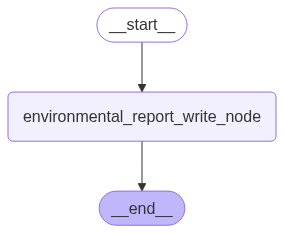

In [76]:
Image(dispatcher_report_graph.get_graph().draw_mermaid_png())

In [77]:
environmental_content_df = dispatcher_daily_df[['environmental_fact']]

In [78]:
environmental_content_str = '\n'.join(environmental_content_df['environmental_fact'])

In [80]:
environmental_content_str

'```markdown\n# 元数据 (Metadata)\n*   **标题:** 6.20中联钢联合钢铁网日报\n*   **链接:** https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625\n\n---\n\n## 政策 (policy)\n*   商务部新闻发言人何亚东表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\n*   商务部新闻发言人何亚东在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\n*   西安市住房和城乡建设局等多部门联合印发《西安市关于促进房地产市场平稳健康发展的若干措施》。措施提到，实施土地出让金分期缴纳。建设单位在签订土地出让合同后一个月内缴纳土地出让价款50%的项目（剩余价款在一年内缴清），可先行办理国有建设用地使用权预登记、规划、建设等相关手续，支持“拿地即开工”。\n\n## 宏观 (macro)\n*   国家发展改革委推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目，其成功发行上市，将有利于深化新型基础设施领域投融资机制创新，更好推动数字经济和人工智能产业发展，有利于拓宽民营企业融资渠道，进一步提振民间投资信心。基础设施REITs是盘活存量资产、促进投融资良性循环的重要方式，是吸引社会资本参与、提高项目运营效率的有效手段。截至目前，国家发展改革委已累计向中国证监会推荐92个基础设施REITs项目，其中70个项目已发行上市，发售基金总额达1794亿元，预计可带动新项目投资超1万亿元。下一步，国家发展

In [88]:
init_dispatcher_report_state = {"environmental_fact":environmental_content_str}

In [89]:
environmental_report = dispatcher_report_graph.invoke(init_dispatcher_report_state)

2025-06-23 14:55:07 [INFO] root:332709162.py:2 - Environmental report write node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/c
2025-06-23 14:55:07 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 14:56:05 [INFO] root:332709162.py:6 - Environmental report write node result:
 # 信息简报：宏观与政策面对钢铁冶金EPC业务的影响分析

---

## 1. 核心商业洞察

*   **整体商业景气度呈现结构性分化**：政策驱动的绿色转型（如碳达峰、再生资源利用）和区域发展（如自贸试验区改革）为EPC行业创造增量机会，但房地产持续低迷（1-5月开发投资下降10.7%）和粗钢产量收缩（5月同比降6.9%）压制传统业务空间。建议采取**审慎扩张**策略——在绿色低碳、智能制造等政策支持领域积极布局，同时收缩高耗能传统产能项目资源投入。

*   **最大机遇在于政策驱动的技术升级项目**：CPTPP对接将倒逼环保标准提升，催生钢厂低碳改造需求；REITs扩容（累计带动投资超1万亿）为钢铁园区综合改造提供新融资渠道。**最严峻挑战**是业主资金链压力——房企债务风险传导至钢铁需求端，叠加美联储高利率延长（2025年仅降息50BP），钢厂业主融资成本高企可能推迟项目。

*   **区域战略需动态调整**：优先关注上海自贸区（跨境融资试点）、粤港澳大湾区（购房结汇便利化）等政策高地，警惕唐山等环保限产重点区域的短期项目波动风险。

---

## 2. 政策环境对EPC业务机遇的影响分析

*   **新兴项目类型涌现**：
    - 再生钢铁原料进口松绑（生态环境部公告）将刺激废钢处理生产线建设需求
    - "无废城市"建设（广东方案）催生钢厂

In [90]:
print(environmental_report['environmental_report'])

# 信息简报：宏观与政策面对钢铁冶金EPC业务的影响分析

---

## 1. 核心商业洞察

*   **整体商业景气度呈现结构性分化**：政策驱动的绿色转型（如碳达峰、再生资源利用）和区域发展（如自贸试验区改革）为EPC行业创造增量机会，但房地产持续低迷（1-5月开发投资下降10.7%）和粗钢产量收缩（5月同比降6.9%）压制传统业务空间。建议采取**审慎扩张**策略——在绿色低碳、智能制造等政策支持领域积极布局，同时收缩高耗能传统产能项目资源投入。

*   **最大机遇在于政策驱动的技术升级项目**：CPTPP对接将倒逼环保标准提升，催生钢厂低碳改造需求；REITs扩容（累计带动投资超1万亿）为钢铁园区综合改造提供新融资渠道。**最严峻挑战**是业主资金链压力——房企债务风险传导至钢铁需求端，叠加美联储高利率延长（2025年仅降息50BP），钢厂业主融资成本高企可能推迟项目。

*   **区域战略需动态调整**：优先关注上海自贸区（跨境融资试点）、粤港澳大湾区（购房结汇便利化）等政策高地，警惕唐山等环保限产重点区域的短期项目波动风险。

---

## 2. 政策环境对EPC业务机遇的影响分析

*   **新兴项目类型涌现**：
    - 再生钢铁原料进口松绑（生态环境部公告）将刺激废钢处理生产线建设需求
    - "无废城市"建设（广东方案）催生钢厂固废协同处置EPC项目
    - 数字人民币国际运营中心设立可能推动钢铁跨境贸易数字化基建项目

*   **投资驱动机制变革**：
    - 自贸离岸债（央行政策）帮助海外钢厂项目突破外汇管制
    - 科技型企业跨境融资便利化（外管局新政）利好氢能炼钢等前沿技术项目融资
    - 需警惕"国补"资金节奏调整（如新疆暂停部分补贴）导致的业主支付延迟风险

*   **准入门槛升级**：
    - CPTPP对接可能引入国际ESG认证要求，EPC企业需提前获取ISO 14064等碳核算资质
    - 钢企A/B级限产（唐山案例）将强化超低排放改造项目的技术壁垒

---

## 3. 宏观经济对业主投资能力的影响分析

*   **业主财务健康预警信号**：
    - PPI持续负向（5月钢材产量增3.4%但粗钢降6.9%）反映钢厂利润空间压缩
    - 基础设施REITs虽扩容，但民